In [11]:
import pyomo.environ as pyo
import matplotlib.pyplot as plt
import datetime as dt

## Formulating the optimization problem

$$
\begin{align*}
e &:= \text{energy on battery} \\
t &:= \text{point in time} \\
cost &:= \text{cost of charging}
\end{align*}
$$

$$
\begin{split}
\textrm{minimize } & \sum_{i=1}^{i=N}{cost_i}\\
\textrm{subject to:} &\\ 
\end{split}

\newline

\begin{align*}
e_{i+1} &= e_i - f(t_{i+1}, t_i, ...) &\text{ if } (t_{i+1} - t_i) \in \text{TRANSIT} \\
e_{i+1} &= e_i + \bar{P} \cdot (t_{i+1} - t_i) &\text{ if } (t_{i+1} - t_i) \in \text{DOCKED} \\
e_0 &= E_{init} \\
cost_i &= C_i \cdot \bar{P} \cdot (t_{i+1} - t_i) &\text{ if } (t_{i+1} - t_i) \in \text{DOCKED} \\
T_i^- &\le t_i \le T_i^+ &\forall i \in N \\
t_{i+1} - t_i &\ge \frac{D}{\bar{V}_{max}} &\forall i \in N-1 \\
E_{min} &\le e_i \le E_{max} &\forall i \in N \\
\end{align*}
$$

In [43]:
# Parameters
NUM_DEPARTURES = 6
state = {'transit':0, 'idle1':1, 'charge':2, 'idle2': 3}
final_state = 'charge'
num_states = len(state)
N = num_states * NUM_DEPARTURES - (num_states - state[final_state] - 1)  # Number of 'time tokens' in the optimization problem. Last state corresponds to "final transit ends"
D = 15_000  # Distance between harbors [meters]
MIN_DOCKING_STAY = 5 * 60  # [seconds]
MIN_IDLE_TIME = 2 * 60  # [seconds]
E_max = 4.3e6 # [Wh]
E_min = 0.2 * E_max # [Wh]
E_init = 0.7*E_max # [Wh]
E_end = 0.7*E_max # [Wh]
P = 2e6 # [W]
V_max = 6.5  # mean average speed [meters/second]

assert 0 < E_min < E_max
assert E_min <= E_init <= E_max
assert E_min <= E_end <= E_max

timetable_delta = 1.5*60*60 # [seconds]
TS = [(lambda x: timetable_delta*x)(x) for x in range(NUM_DEPARTURES+1)]
print("Time schedule (arrival times):", TS)

print(f"Min travel time: {D/V_max:,.0f} seconds ({D/(3600*V_max):,.2f} hours)")
print(f"Max travel time wo/ stop: {3600*E_max/P:,.0f} sec ({E_max/P} hours))")
print(f"Max travel distance wo/ charging: {V_max * (3600*E_max/P):,.0f} meters")
# print(f"Max energy consumption: {P*")

Time schedule (arrival times): [0.0, 5400.0, 10800.0, 16200.0, 21600.0, 27000.0, 32400.0]
Min travel time: 2,308 seconds (0.64 hours)
Max travel time wo/ stop: 7,740 sec (2.15 hours))
Max travel distance wo/ charging: 50,310 meters


In [44]:
# Create model
m = pyo.ConcreteModel()
m.name = "Optimal Ferry Charging Schedule"

# Define sets
m.SetAll = pyo.SetOf(range(N))
m.SetAll_1 = pyo.SetOf(range(N-1))
m.SetTransit = pyo.SetOf(range(state['transit'], N, num_states))
m.SetCharge = pyo.SetOf(range(state['charge'], N-1, num_states))  # Final 'charge' state represents "final transit ends"
m.SetIdle1 = pyo.SetOf(range(state['idle1'], N, num_states))
m.SetIdle1_1 = pyo.SetOf(range(state['idle1'], N-2, num_states))
m.SetIdle2 = pyo.SetOf(range(state['idle2'], N-1, num_states))
m.SetIdleBoth = m.SetIdle1.union(m.SetIdle2)

# Define variables
## Time
m.t = pyo.Var(m.SetAll, within=pyo.NonNegativeReals)
m.t[0].fix(TS[0])
m.t[N-1].fix(TS[-1])

# Energy
m.e = pyo.Var(m.SetAll, within=pyo.NonNegativeReals, bounds=(E_min, E_max))
m.e[0].fix(E_init)
m.e[N-1].fix(E_end)

# Cost (Odd index numbers represent charging at the dock)
m.cost = pyo.Var(m.SetCharge, domain=pyo.NonNegativeReals)

In [45]:
# Define constraints
## Time
def constraint_time_order(m, i):
    return m.t[i+1] >= m.t[i]
m.constraint_time_order = pyo.Constraint(m.SetAll_1, rule=constraint_time_order)
# m.constraint_time_order = pyo.Constraint(m.SetAll[:-1], rule=constraint_time_order)

### Transit
def constraint_transit_length(m, i):
    return m.t[i+1] - m.t[i] >= D/V_max
m.constraint_transit_length = pyo.Constraint(m.SetTransit, rule=constraint_transit_length)

### Docked
def constraint_arrival_bounds(m, i):
    ts_i = int(1 + (i-1)/num_states)
    return (TS[ts_i] - MIN_DOCKING_STAY, m.t[i], TS[ts_i])
m.constraint_arrival_bounds = pyo.Constraint(m.SetIdle1, rule=constraint_arrival_bounds)

def constraint_min_docked_timeslot_length(m, i):
    dock_delta = state['idle2'] - state['transit']
    return m.t[i+dock_delta] - m.t[i] >= MIN_DOCKING_STAY
m.constraint_min_docked_timeslot_length = pyo.Constraint(m.SetIdle1_1, rule=constraint_min_docked_timeslot_length)

### Idle
def constraint_min_idle_timeslot_length(m, i):
    return m.t[i+1] - m.t[i] >= MIN_IDLE_TIME
m.constraint_min_idle_timeslot_length = pyo.Constraint(m.SetIdleBoth, rule=constraint_min_idle_timeslot_length)

## Energy
## Transit
def constraint_energy_transit(m, i):
    return m.e[i+1] == m.e[i] - P/2 * (m.t[i+1] - m.t[i])/3600  # TODO: Replace this with the predicted consumption
m.constraint_energy_transit = pyo.Constraint(m.SetTransit, rule=constraint_energy_transit)

# ### Charging
def constraint_energy_charging(m, i):
    return m.e[i+1] == m.e[i] + P * (m.t[i+1] - m.t[i])/3600
m.constraint_energy_charging = pyo.Constraint(m.SetCharge, rule=constraint_energy_charging)

def constraint_energy_idle(m, i):
    return m.e[i+1] == m.e[i] - P/4 * (m.t[i+1] - m.t[i])/3600
m.constraint_energy_idle = pyo.Constraint(m.SetIdleBoth, rule=constraint_energy_idle)

## Cost
def constraint_cost(m, i):
    return m.cost[i] == 10.0 * P * (m.t[i+1] - m.t[i])/3600
m.constraint_cost = pyo.Constraint(m.SetCharge, rule=constraint_cost)

In [46]:
# Define objective function
def objective(m):
    return sum(m.cost[i] for i in m.SetCharge)
m.objective = pyo.Objective(rule=objective, sense=pyo.minimize, doc="Total cost")

In [47]:
results = pyo.SolverFactory('cbc').solve(m)
# results.write()
print(results['Solver'][0]['Termination message'])

Model was solved to optimality (subject to tolerances), and an optimal solution is available.


In [48]:
points_in_time = list(m.t.extract_values().values())
begin = [x for x in points_in_time[:N]]
end = [x for x in points_in_time[1:]]

energy = list(m.e.extract_values().values())

cost = list(m.cost.extract_values().values())

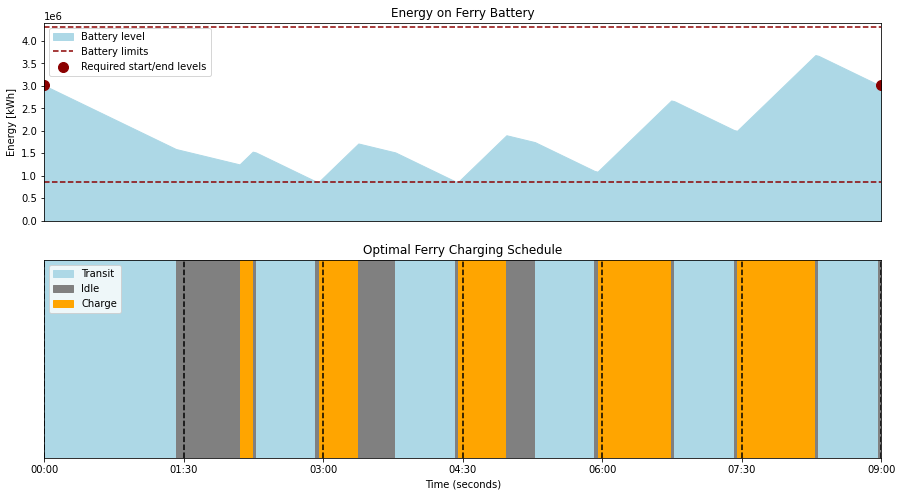

In [49]:

figs, axs = plt.subplots(nrows=2, figsize=(15, 8))

# Plot energy
axs[0].fill_between(points_in_time, 0, energy, color='lightblue')
axs[0].add_line(plt.Line2D([points_in_time[0], points_in_time[-1], None, points_in_time[0], points_in_time[-1]], [E_max, E_max, None, E_min, E_min], color='darkred', linestyle='--'))
# axs[0].add_line(plt.Line2D([points_in_time[0], points_in_time[-1]], [E_min, E_min], color='darkred', linestyle='--'))
axs[0].scatter([points_in_time[0], points_in_time[-1]], [E_init, E_end], color='darkred', s=100, label='Initial and final energy')

axs[0].title.set_text("Energy on Ferry Battery")
axs[0].set_ylabel("Energy [kWh]")
axs[0].legend(['Battery level', 'Battery limits', 'Required start/end levels'],loc="upper left")
axs[0].get_xaxis().set_visible(False)
axs[0].set_xlim(TS[0],TS[-1])
axs[0].set_ylim(0,E_max+1e5)

# Plot schedule
c = 'lightblue'
for i, (t1 , t2) in enumerate(zip(begin ,end)):
    if i % num_states == state['transit']:
        c = 'lightblue'
    elif i % num_states == state['charge']:
        c = 'orange'
    else:
        c = 'grey'
    axs[1].add_patch(plt.Rectangle((t1,0),t2-t1,1, color=c))

for t in TS:
    axs[1].add_line(plt.Line2D([t, t], [0, 1], color='black', linestyle='--'))

axs[1].title.set_text("Optimal Ferry Charging Schedule")
axs[1].legend(['Transit', 'Idle', 'Charge'], loc="upper left")
axs[1].set_xlabel("Time (seconds)")
axs[1].set_xlim(TS[0],TS[-1])
axs[1].get_yaxis().set_visible(False)

# pretty_ticks = [(dt.datetime.now() + dt.timedelta(seconds=(t - TS[0]))).strftime("%H:%M:%S") for t in TS]
# axs[1].set_xticks(points_in_time, pretty_ticks)
from matplotlib.ticker import FuncFormatter
import time
formatter = FuncFormatter(lambda s, x: time.strftime('%H:%M', time.gmtime(s)))
axs[1].xaxis.set_major_formatter(formatter)

axs[1].xaxis.set_major_locator(plt.MultipleLocator(timetable_delta))


plt.show()